# F78DS Data Science Life Cycle – Coursework 1

**Name:** Ng Jia Ning
**Student ID:** H00479060
**Date:** 2026-02-21

---

## Introduction

This notebook investigates demographic changes in **Malaysia**, the **United Arab Emirates (UAE)**, and the **United Kingdom (UK)**, and explores how these factors relate to **primary school enrolments**. 

This notebook follows a basic data science workflow.
1. Load the datasets (UN population Excel + World Bank enrolment CSV).
2. Inspect structure and data quality (types, missing values, year coverage).
3. Wrangle into tidy format and keep only the 3 countries of interest.
4. Engineer the feature **Eligible Primary Age Population** (with justified assumptions/sources).
5. Produce statistics and visualisations, then discuss findings with online references.

All outputs (tables/plots) are generated by running the code cells in order.

## Requirement checklist (mapped to this notebook)

To make marking easier, this section maps common coursework requirements to where they are addressed:

- **Data files stored in a local `data/` folder and verified** → *Data location (required)* + file existence check code.
- **Load both required datasets correctly** → UN Excel (`Estimates` sheet) + World Bank CSV (`skiprows=4`).
- **Describe, clean and subset data for the 3 required countries** → initial dataset description + subsetting + renaming and type checks.
- **Reshape enrolment data into tidy format** → wide-to-long transformation (`country`, `Year`, `enrolment`).
- **Handle missing values and assess year coverage** → missingness summary and per-country coverage table.
- **Merge datasets and justify join choice** → left join on (`country`, `Year`) with merge-quality checks.
- **Feature engineering with justified assumptions** → natural change + estimated eligible primary-age population (12%) and sensitivity check (10%/12%/14%).
- **Visual analysis and interpretation** → enrolment trends, population vs enrolment, migration trends, and population-change driver comparisons.
- **Conclusions and references** → discussion/insights section plus source list.


## Data location (required)

Both data files were saved inside a folder named **`data/`** in the same directory as this notebook, as required in the specification:

- `data/UN_Population_Data.xlsx`
- `data/Primary_School_Enrolments.csv`

In [1]:
from pathlib import Path

DATA_DIR = Path("data")
UN_FILE = DATA_DIR / "UN_Population_Data.xlsx"
ENROL_FILE = DATA_DIR / "Primary_School_Enrolments.csv"

print("UN file exists:", UN_FILE.exists(), "| path:", UN_FILE)
print("Enrol file exists:", ENROL_FILE.exists(), "| path:", ENROL_FILE)

UN file exists: True | path: data\UN_Population_Data.xlsx
Enrol file exists: True | path: data\Primary_School_Enrolments.csv


## Importing libraries

I use:
- `pandas` for loading and wrangling data,
- `numpy` for numeric operations,
- `matplotlib` for plotting,
- and some utility libraries for file checks and display.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 120)
plt.style.use("seaborn-v0_8-whitegrid")


## Part 1 – Reading the UN Population Excel file

The UN dataset is provided as an Excel file.  
The specification states we only need **Sheet 1 (Estimates)**.  
I will load this sheet and inspect the resulting dataframe to confirm it is read correctly.

In [3]:
df_un_raw = pd.read_excel(UN_FILE, sheet_name="Estimates", header=16)
df_un_raw.head()

,Index,Variant,"Region, subregion, country or area *",Notes,Location code,ISO3 Alpha-code,ISO2 Alpha-code,SDMX code**,Type,Parent code,Year,"Total Population, as of 1 January (thousands)","Total Population, as of 1 July (thousands)","Male Population, as of 1 July (thousands)","Female Population, as of 1 July (thousands)","Population Density, as of 1 July (persons per square km)","Population Sex Ratio, as of 1 July (males per 100 females)","Median Age, as of 1 July (years)","Natural Change, Births minus Deaths (thousands)","Rate of Natural Change (per 1,000 population)",Population Change (thousands),Population Growth Rate (percentage),Population Annual Doubling Time (years),Births (thousands),Births by women aged 15 to 19 (thousands),"Crude Birth Rate (births per 1,000 population)",Total Fertility Rate (live births per woman),Net Reproduction Rate (surviving daughters per woman),Mean Age Childbearing (years),Sex Ratio at Birth (males per 100 female births),Total Deaths (thousands),Male Deaths (thousands),Female Deaths (thousands),"Crude Death Rate (deaths per 1,000 population)","Life Expectancy at Birth, both sexes (years)",Male Life Expectancy at Birth (years),Female Life Expectancy at Birth (years),"Life Expectancy at Age 15, both sexes (years)",Male Life Expectancy at Age 15 (years),Female Life Expectancy at Age 15 (years),"Life Expectancy at Age 65, both sexes (years)",Male Life Expectancy at Age 65 (years),Female Life Expectancy at Age 65 (years),"Life Expectancy at Age 80, both sexes (years)",Male Life Expectancy at Age 80 (years),Female Life Expectancy at Age 80 (years),"Infant Deaths, under age 1 (thousands)","Infant Mortality Rate (infant deaths per 1,000 live births)",Live Births Surviving to Age 1 (thousands),"Under-Five Deaths, under age 5 (thousands)","Under-Five Mortality (deaths under age 5 per 1,000 live births)","Mortality before Age 40, both sexes (deaths under age 40 per 1,000 live births)","Male Mortality before Age 40 (deaths under age 40 per 1,000 male live births)","Female Mortality before Age 40 (deaths under age 40 per 1,000 female live births)","Mortality before Age 60, both sexes (deaths under age 60 per 1,000 live births)","Male Mortality before Age 60 (deaths under age 60 per 1,000 male live births)","Female Mortality before Age 60 (deaths under age 60 per 1,000 female live births)","Mortality between Age 15 and 50, both sexes (deaths under age 50 per 1,000 alive at age 15)","Male Mortality between Age 15 and 50 (deaths under age 50 per 1,000 males alive at age 15)","Female Mortality between Age 15 and 50 (deaths under age 50 per 1,000 females alive at age 15)","Mortality between Age 15 and 60, both sexes (deaths under age 60 per 1,000 alive at age 15)","Male Mortality between Age 15 and 60 (deaths under age 60 per 1,000 males alive at age 15)","Female Mortality between Age 15 and 60 (deaths under age 60 per 1,000 females alive at age 15)",Net Number of Migrants (thousands),"Net Migration Rate (per 1,000 population)"
0,1,Estimates,World,NaN,900,NaN,NaN,1.0,World,0,1950.0,2471424.002,2493092.848,1241431.646,1251661.202,19.118,99.183,22.159,43337.044,17.383,43337.691,1.738,39.882,91823.936,10492.124,36.831,4.852,1.632,28.914,105.4,48486.892,25664.047,22822.845,19.448,46.394,44.465,48.436,47.192,45.02,49.475,11.382,10.547,12.126,5.069,4.76,5.285,12546.353,138.135,82937.226,19962.067,227.187,374.11,391.359,356.485,539.941,580.5,497.388,238.516,268.734,207.62,375.391,426.221,322.65,0,0
1,2,Estimates,World,NaN,900,NaN,NaN,1.0,World,0,1951.0,2514761.693,2536927.035,1263362.496,1273564.539,19.454,99.199,22.123,44330.966,17.474,44330.684,1.747,39.676,92507.128,10573.672,36.464,4.816,1.638,28.882,105.4,48176.162,25384.18,22791.982,18.99,47.126,45.3,49.04,47.643,45.611,49.761,11.423,10.585,12.165,5.058,4.754,5.271,12566.473,136.046,83687.571,19948.675,221.468,363.364,378.095,348.376,528.233,566.566,488.435,229.703,256.236,202.734,365.226,412.76,316.395,0,0
2,3,Estimates,World,NaN,900,NaN,NaN,1.0,World,0,1952.0

In [4]:
print("Shape:", df_un_raw.shape)
print("First 15 columns:", df_un_raw.columns.tolist()[:15])

print("Year range:", df_un_raw["Year"].min(), "to", df_un_raw["Year"].max())
df_un_raw[["Region, subregion, country or area *", "Year"]].head(10)

Shape: (21983, 65)
First 15 columns: ['Index', 'Variant', 'Region, subregion, country or area *', 'Notes', 'Location code', 'ISO3 Alpha-code', 'ISO2 Alpha-code', 'SDMX code**', 'Type', 'Parent code', 'Year', 'Total Population, as of 1 January (thousands)', 'Total Population, as of 1 July (thousands)', 'Male Population, as of 1 July (thousands)', 'Female Population, as of 1 July (thousands)']
Year range: 1950.0 to 2023.0


,"Region, subregion, country or area *",Year
0,World,1950.0
1,World,1951.0
2,World,1952.0
3,World,1953.0
4,World,1954.0
5,World,1955.0
6,World,1956.0
7,World,1957.0
8,World,1958.0
9,World,1959.0


## Part 1 – Reading the Primary School Enrolments CSV (World Bank format)

This World Bank CSV contains metadata lines at the top, so I skip the first 4 rows and then load the data.
After loading, I check the structure and key columns to confirm it is read correctly.

In [5]:
df_enrol_raw = pd.read_csv(ENROL_FILE, skiprows=4)
df_enrol_raw.head()

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,Unnamed: 69
0,Aruba,ABW,"Primary education, pupils",SE.PRM.ENRL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9096.0,9263.0,9436.0,9840.0,9897.0,10185.0,10250.0,10390.0,10346.0,10012.0,9944.0,9231.0,9535.0,9694.0,9791.0,9816.0,9577.0,9391.0,NaN,8736.0,8642.0,8448.0,8398.0,7714.0,NaN,7719.0,NaN
1,Africa Eastern and Southern,AFE,"Primary education, pupils",SE.PRM.ENRL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19760248.0,19237090.0,19992448.0,20860424.0,22621776.0,23909982.0,25110340.0,26347658.0,27416116.0,29268166.0,31264122.0,32692678.0,33672588.0,34341676.0,34801192.0,34597788.0,35378144.0,35859244.0,36631292.0,38461140.0,38295988.0,40174788.0,40442368.0,42123588.0,43198592.0,45538828.0,46526624.0,50018328.0,51625832.0,52120304.0,54585108.0,57801984.0,60955680.0,65256504.0,68481288.0,72684280.0,76345256.0,81806896.0,86885000.0,88636152.0,90179080.0,92441616.0,95055512.0,97300976.0,100076632.0,101477368.0,104837552.0,108406080.0,112417552.0,115847760.0,119130712.0,119747560.0,118358656.0,119810368.0,121027968.0,NaN
2,Afghanistan,AFG,"Primary education, pupils",SE.PRM.ENRL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,540685.0,572933.0,597509.0,624374.0,654209.0,692342.0,729667.0,764175.0,810657.0,NaN,959583.0,1024741.0,365458.0,NaN,447351.0,479150.0,512809.0,NaN,651622.0,622135.0,622513.0,627888.0,NaN,786532.0,1161444.0,1312197.0,NaN,NaN,1046338.0,875605.0,749360.0,773623.0,2667629.0,3781015.0,4430142.0,4318819.0,4669110.0,4718077.0,4974836.0,4945632.0,5279326.0,5291624.0,5767543.0,5986268.0,6217756.0,6199329.0,6265011.0,6350404.0,6544906.0,6777785.0,NaN,NaN,NaN,NaN,NaN,NaN
3,Africa Western and Central,AFW,"Primary education, pupils",SE.PRM.ENRL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8064369.0,8612076.0,9262617.0,9840475.0,10155358.0,10550301.0,10982013.0,12624778.0,14892847.0,17074448.0,18390914.0,20070922.0,22057028.0,22904582.0,23426204.0,23547004.0,22436870.0,22689844.0,22841512.0,23283912.0,24436996.0,25106566.0,26395516.0,27893874.0,28696642.0,28820840.0,27615712.0,29692606.0,31641668.0,33666376.0,35908908.0,37072632.0,38850492.0,40216864.0,42228620.0,43820840.0,45448912.0,45395008.0,45484228.0,47813412.0,49764476.0,53310196.0,55902976.0,58294892.0,59049804.0,59493736.0,60993404.0,62858176.0,64506332.0,66820876.0,68840464.0,70302024.0,72806080.0,75093880.0,75774088.0,NaN
4,Angola,AGO,"Primary education, pupils",SE.PRM.ENRL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,434370.0,485955.0,516131.0,576420.0,NaN,NaN,NaN,NaN,NaN,1420839.0,1300673.0,1258858.0,1178430.0,1065025.0,870410.0,974498.0,1012303.0,1031314.0,1067906.0,1041126.0,990155.0,989444.0,NaN,NaN,NaN,NaN,NaN,1342116.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3558605.0,3930051.0,4046266.0,4273006.0,5026803.0,NaN,NaN,NaN,5620915.0,NaN,NaN,NaN,NaN,NaN,5217940.0,NaN,5383867.0,NaN,NaN


In [6]:
print("Shape:", df_enrol_raw.shape)
print("First 12 columns:", df_enrol_raw.columns.tolist()[:12])

df_enrol_raw[["Country Name", "Country Code", "Indicator Name", "Indicator Code"]].head(10)

Shape: (266, 70)
First 12 columns: ['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code', '1960', '1961', '1962', '1963', '1964', '1965', '1966', '1967']


,Country Name,Country Code,Indicator Name,Indicator Code
0,Aruba,ABW,"Primary education, pupils",SE.PRM.ENRL
1,Africa Eastern and Southern,AFE,"Primary education, pupils",SE.PRM.ENRL
2,Afghanistan,AFG,"Primary education, pupils",SE.PRM.ENRL
3,Africa Western and Central,AFW,"Primary education, pupils",SE.PRM.ENRL
4,Angola,AGO,"Primary education, pupils",SE.PRM.ENRL
5,Albania,ALB,"Primary education, pupils",SE.PRM.ENRL
6,Andorra,AND,"Primary education, pupils",SE.PRM.ENRL
7,Arab World,ARB,"Primary education, pupils",SE.PRM.ENRL
8,United Arab Emirates,ARE,"Primary education, pupils",SE.PRM.ENRL
9,Argentina,ARG,"Primary education, pupils",SE.PRM.ENRL


## Part 1 – Initial description of the datasets

**UN Population dataset (Excel):**
- Time-series demographic indicators by country and year.
- Main columns used here: total population, births, deaths, net migrants, and year.
- Values are reported in **thousands** and must be converted to actual counts.

**Primary School Enrolments dataset (CSV):**
- Country-level primary school enrolment totals from the World Bank.
- The file is initially in **wide format** (one column per year), so it must be reshaped to **tidy long format** (`country`, `Year`, `enrolment`).

These two datasets are complementary: UN data provides demographic drivers, while World Bank data provides observed enrolment outcomes.


## Part 1 – Subsetting the required countries

In [7]:
countries = ["Malaysia", "United Arab Emirates", "United Kingdom"]

df_un = df_un_raw[
    df_un_raw["Region, subregion, country or area *"].isin(countries)
].copy()

df_un.head()

,Index,Variant,"Region, subregion, country or area *",Notes,Location code,ISO3 Alpha-code,ISO2 Alpha-code,SDMX code**,Type,Parent code,Year,"Total Population, as of 1 January (thousands)","Total Population, as of 1 July (thousands)","Male Population, as of 1 July (thousands)","Female Population, as of 1 July (thousands)","Population Density, as of 1 July (persons per square km)","Population Sex Ratio, as of 1 July (males per 100 females)","Median Age, as of 1 July (years)","Natural Change, Births minus Deaths (thousands)","Rate of Natural Change (per 1,000 population)",Population Change (thousands),Population Growth Rate (percentage),Population Annual Doubling Time (years),Births (thousands),Births by women aged 15 to 19 (thousands),"Crude Birth Rate (births per 1,000 population)",Total Fertility Rate (live births per woman),Net Reproduction Rate (surviving daughters per woman),Mean Age Childbearing (years),Sex Ratio at Birth (males per 100 female births),Total Deaths (thousands),Male Deaths (thousands),Female Deaths (thousands),"Crude Death Rate (deaths per 1,000 population)","Life Expectancy at Birth, both sexes (years)",Male Life Expectancy at Birth (years),Female Life Expectancy at Birth (years),"Life Expectancy at Age 15, both sexes (years)",Male Life Expectancy at Age 15 (years),Female Life Expectancy at Age 15 (years),"Life Expectancy at Age 65, both sexes (years)",Male Life Expectancy at Age 65 (years),Female Life Expectancy at Age 65 (years),"Life Expectancy at Age 80, both sexes (years)",Male Life Expectancy at Age 80 (years),Female Life Expectancy at Age 80 (years),"Infant Deaths, under age 1 (thousands)","Infant Mortality Rate (infant deaths per 1,000 live births)",Live Births Surviving to Age 1 (thousands),"Under-Five Deaths, under age 5 (thousands)","Under-Five Mortality (deaths under age 5 per 1,000 live births)","Mortality before Age 40, both sexes (deaths under age 40 per 1,000 live births)","Male Mortality before Age 40 (deaths under age 40 per 1,000 male live births)","Female Mortality before Age 40 (deaths under age 40 per 1,000 female live births)","Mortality before Age 60, both sexes (deaths under age 60 per 1,000 live births)","Male Mortality before Age 60 (deaths under age 60 per 1,000 male live births)","Female Mortality before Age 60 (deaths under age 60 per 1,000 female live births)","Mortality between Age 15 and 50, both sexes (deaths under age 50 per 1,000 alive at age 15)","Male Mortality between Age 15 and 50 (deaths under age 50 per 1,000 males alive at age 15)","Female Mortality between Age 15 and 50 (deaths under age 50 per 1,000 females alive at age 15)","Mortality between Age 15 and 60, both sexes (deaths under age 60 per 1,000 alive at age 15)","Male Mortality between Age 15 and 60 (deaths under age 60 per 1,000 males alive at age 15)","Female Mortality between Age 15 and 60 (deaths under age 60 per 1,000 females alive at age 15)",Net Number of Migrants (thousands),"Net Migration Rate (per 1,000 population)"
9476,9477,Estimates,Malaysia,9,458,MYS,MY,458.0,Country/Area,920,1950.0,6020.288,6098.283,3146.257,2952.026,18.561,106.58,18.826,148.646,24.375,155.991,2.558,27.097,272.659,29.138,44.711,6.429,2.333,29.326,105.8,124.013,66.442,57.572,20.336,48.491,47.921,49.204,44.959,44.636,45.444,8.641,8.385,8.949,3.519,3.483,3.558,30.316,114.826,250.717,42.679,169.647,312.363,308.813,316.359,532.586,549.484,510.966,246.983,245.566,246.321,416.862,434.244,393.945,7.343,1.204
9477,9478,Estimates,Malaysia,9,458,MYS,MY,458.0,Country/Area,920,1951.0,6176.279,6257.417,3225.843,3031.574,19.046,106.408,18.465,158.563,25.34,162.276,2.593,26.731,279.241,29.833,44.626,6.428,2.373,29.345,105.7,120.678,65.122,55.556,19.286,49.221,48.473,50.144,45.092,44.58,45.794,8.733,8.46,9.057,3.566,3.524,3.61,30.382,109.631,257.785,42.434,160.122,302.671,302.635,302.876,523.83,544.123,497.845,245.394,248.363,239.92,413.799,434.846,386.213,3.712,0.593
9478,9479,Estimates,Malaysia,9,458,MYS,MY,458.0,Country/Area,920,1952.0,6338

In [8]:
df_un["Region, subregion, country or area *"].unique()

array(['Malaysia', 'United Arab Emirates', 'United Kingdom'], dtype=object)

In [9]:
df_enrol = df_enrol_raw[
    df_enrol_raw["Country Name"].isin(countries)
].copy()

df_enrol.head()

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,Unnamed: 69
8,United Arab Emirates,ARE,"Primary education, pupils",SE.PRM.ENRL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22009.0,26130.0,30495.0,34731.0,40229.0,52207.0,60742.0,67058.0,72627.0,80470.0,88617.0,103937.0,115211.0,126726.0,137700.0,152125.0,165463.0,180270.0,197869.0,215532.0,228980.0,231674.0,238469.0,251182.0,262628.0,260919.0,259509.0,262653.0,270486.0,273144.0,280248.0,285744.0,248370.0,254602.0,262807.0,272331.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,642987.0,654732.0,532702.0,517647.0,534889.0,554644.0,586477.0,NaN
81,United Kingdom,GBR,"Primary education, pupils",SE.PRM.ENRL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5806349.0,5880238.0,5888063.0,5876761.0,5811517.0,5725167.0,5636473.0,5495784.0,5326864.0,5133710.0,4910724.0,4688572.0,4474000.0,4368700.0,4275000.0,4296000.0,4322000.0,4370000.0,4414966.0,4487000.0,4532500.0,4559500.0,NaN,NaN,NaN,NaN,NaN,4664429.0,4661234.0,4631623.0,4596110.0,4536143.0,4488162.0,4685733.0,4634991.0,4517618.0,4409184.0,4465021.0,4416474.0,4421903.0,4419840.0,4523583.0,4622158.0,4509479.0,4621192.0,4721647.0,4820283.0,4892502.0,4919259.0,4903628.0,4867378.0,4865495.5,4864955.5,NaN,NaN
169,Malaysia,MYS,"Primary education, pupils",SE.PRM.ENRL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1684263.0,NaN,NaN,NaN,NaN,1893323.0,NaN,1929914.0,1968304.0,1986141.0,2008973.0,2034256.0,2072393.0,2120050.0,2148748.0,2199096.0,NaN,2274453.0,2338418.0,2397816.0,2455525.0,2540623.0,2626297.0,2693632.0,2744993.0,2799744.0,2856613.0,NaN,2887753.0,2911773.0,3025977.0,3033019.0,3009009.0,3056266.0,3159376.0,3202008.0,3217329.0,3221408.0,3225487.0,3229566.0,3233645.0,3237724.0,3241803.0,3245882.0,3178364.0,3107870.0,3101007.0,3084630.0,3068441.0,3066391.0,3081723.0,3087886.0,3024466.0,3092312.0,3055288.0,NaN


In [10]:
df_enrol["Country Name"].unique()

array(['United Arab Emirates', 'United Kingdom', 'Malaysia'], dtype=object)

## Part 1 – Cleaning and renaming columns

The original datasets contain long column names and unnecessary metadata.
To make analysis easier and clearer, I select only the required columns and rename them into simpler, consistent variable names.

In [11]:
# select only useful columns
df_un = df_un[[
    "Region, subregion, country or area *",
    "Year",
    "Total Population, as of 1 July (thousands)",
    "Births (thousands)",
    "Total Deaths (thousands)",
    "Net Number of Migrants (thousands)"
]].copy()

# rename columns to clean names
df_un = df_un.rename(columns={
    "Region, subregion, country or area *": "country",
    "Total Population, as of 1 July (thousands)": "population_thousands",
    "Births (thousands)": "births_thousands",
    "Total Deaths (thousands)": "deaths_thousands",
    "Net Number of Migrants (thousands)": "net_migrants_thousands"
})

df_un.head()

,country,Year,population_thousands,births_thousands,deaths_thousands,net_migrants_thousands
9476,Malaysia,1950.0,6098.283,272.659,124.013,7.343
9477,Malaysia,1951.0,6257.417,279.241,120.678,3.712
9478,Malaysia,1952.0,6422.846,286.024,116.28,-1.168
9479,Malaysia,1953.0,6593.943,293.634,112.034,-7.98
9480,Malaysia,1954.0,6772.378,301.475,108.55,-9.666


In [12]:
df_un.columns

Index(['country', 'Year', 'population_thousands', 'births_thousands', 'deaths_thousands', 'net_migrants_thousands'], dtype='object')

## Converting units

The UN file stores population, births, deaths, and net migration in **thousands**.
To compare directly with enrolment counts, I convert these fields into actual numbers (`* 1000`).

I then check data types and missing values before merging.


In [13]:
# convert thousands to actual counts
df_un["population"] = df_un["population_thousands"] * 1000
df_un["births"] = df_un["births_thousands"] * 1000
df_un["deaths"] = df_un["deaths_thousands"] * 1000
df_un["net_migrants"] = df_un["net_migrants_thousands"] * 1000

# drop old thousand columns
df_un = df_un.drop(columns=[
    "population_thousands",
    "births_thousands",
    "deaths_thousands",
    "net_migrants_thousands"
])

df_un.head()

,country,Year,population,births,deaths,net_migrants
9476,Malaysia,1950.0,6098283.0,272659.0,124013.0,7343.0
9477,Malaysia,1951.0,6257417.0,279241.0,120678.0,3712.0
9478,Malaysia,1952.0,6422846.0,286024.0,116280.0,-1168.0
9479,Malaysia,1953.0,6593943.0,293634.0,112034.0,-7980.0
9480,Malaysia,1954.0,6772378.0,301475.0,108550.0,-9666.0


In [14]:
# --- Fix dtypes: make sure numeric columns are numeric (not object) ---
df_un["Year"] = pd.to_numeric(df_un["Year"], errors="coerce").astype("Int64")

num_cols = ["population", "births", "deaths", "net_migrants"]
for c in num_cols:
    df_un[c] = pd.to_numeric(df_un[c], errors="coerce")

# Remove rows with missing year and check duplicate country-year rows
before_rows = len(df_un)
df_un = df_un.dropna(subset=["Year"]).copy()
dup_count = df_un.duplicated(subset=["country", "Year"]).sum()

df_un["Year"] = df_un["Year"].astype(int)

print(f"Rows before dropna Year: {before_rows}, after: {len(df_un)}")
print(f"Duplicate country-year rows in UN data: {dup_count}")
print(df_un[num_cols].isna().sum())
print(df_un.dtypes)
df_un.head()


Rows before dropna Year: 222, after: 222
Duplicate country-year rows in UN data: 0
population      0
births          0
deaths          0
net_migrants    0
dtype: int64
country          object
Year              int64
population      float64
births          float64
deaths          float64
net_migrants    float64
dtype: object


,country,Year,population,births,deaths,net_migrants
9476,Malaysia,1950,6098283.0,272659.0,124013.0,7343.0
9477,Malaysia,1951,6257417.0,279241.0,120678.0,3712.0
9478,Malaysia,1952,6422846.0,286024.0,116280.0,-1168.0
9479,Malaysia,1953,6593943.0,293634.0,112034.0,-7980.0
9480,Malaysia,1954,6772378.0,301475.0,108550.0,-9666.0


In [15]:
df_un.columns

Index(['country', 'Year', 'population', 'births', 'deaths', 'net_migrants'], dtype='object')

## Part 1 – Reshaping enrolment data (wide → long format)

The enrolment dataset is currently stored in a wide format,
where each year is a separate column.

To make analysis easier and consistent with tidy data principles,
I reshape it into a long format where each row represents:

(country, year, enrolment)

In [16]:
# identify year columns safely (numeric strings only, e.g. '1960', '1961', ...)
year_columns = sorted([col for col in df_enrol.columns if str(col).isdigit()], key=int)

# reshape into long format
df_enrol_long = df_enrol.melt(
    id_vars=["Country Name"],
    value_vars=year_columns,
    var_name="Year",
    value_name="enrolment"
)

# rename country column for consistency
df_enrol_long = df_enrol_long.rename(columns={"Country Name": "country"})

df_enrol_long.head()


,country,Year,enrolment
0,United Arab Emirates,1960,NaN
1,United Kingdom,1960,NaN
2,Malaysia,1960,NaN
3,United Arab Emirates,1961,NaN
4,United Kingdom,1961,NaN


In [17]:
df_enrol_long.head(10)

,country,Year,enrolment
0,United Arab Emirates,1960,NaN
1,United Kingdom,1960,NaN
2,Malaysia,1960,NaN
3,United Arab Emirates,1961,NaN
4,United Kingdom,1961,NaN
5,Malaysia,1961,NaN
6,United Arab Emirates,1962,NaN
7,United Kingdom,1962,NaN
8,Malaysia,1962,NaN
9,United Arab Emirates,1963,NaN


In [18]:
# convert data types
df_enrol_long["Year"] = df_enrol_long["Year"].astype(int)
df_enrol_long["enrolment"] = pd.to_numeric(df_enrol_long["enrolment"], errors="coerce")

df_enrol_long.dtypes

country       object
Year           int64
enrolment    float64
dtype: object

Year is converted to integer type and enrolment values are converted to numeric.
Any non-numeric entries are coerced to NaN to properly handle missing data.

## Handling missing values and checking year coverage

The World Bank enrolment series has missing years for some countries.
I report:
- total missing enrolment values,
- number of available observations per country,
- first and last valid year per country.

This is important because later comparisons should focus on years where data is available.


In [19]:
df_enrol_long["enrolment"].isna().sum(), df_enrol_long.shape[0]

(np.int64(56), 195)

In [20]:
df_enrol_long.groupby("country")["enrolment"].apply(lambda s: s.notna().sum())

country
Malaysia                48
United Arab Emirates    43
United Kingdom          48
Name: enrolment, dtype: int64

In [21]:
# Avoid FutureWarning from DataFrameGroupBy.apply by using explicit filtering + groupby.agg
coverage_input = df_enrol_long.copy()
coverage_input["Year_with_enrolment"] = coverage_input["Year"].where(coverage_input["enrolment"].notna())

coverage_by_country = (
    coverage_input.groupby("country", as_index=False)
    .agg(
        first_year_with_data=("Year_with_enrolment", "min"),
        last_year_with_data=("Year_with_enrolment", "max"),
        non_missing_points=("enrolment", lambda s: s.notna().sum()),
    )
)

coverage_by_country


,country,first_year_with_data,last_year_with_data,non_missing_points
0,Malaysia,1970.0,2024.0,48
1,United Arab Emirates,1971.0,2024.0,43
2,United Kingdom,1971.0,2023.0,48


## Merging datasets

I merge the cleaned UN demographic table with enrolment using a **left join** on (`country`, `Year`).
This keeps all demographic rows and attaches enrolment where available.

After merging, I check row counts and missing enrolment by country. I also define a practical
analysis window for visual comparisons to avoid overstating periods where enrolment is mostly missing.


In [22]:
df_un["Year"] = df_un["Year"].astype(int)
df_un.dtypes

country          object
Year              int64
population      float64
births          float64
deaths          float64
net_migrants    float64
dtype: object

In [23]:
df_merged = pd.merge(
    df_un,
    df_enrol_long,
    on=["country", "Year"],
    how="left"
)

df_merged.head(10)

,country,Year,population,births,deaths,net_migrants,enrolment
0,Malaysia,1950,6098283.0,272659.0,124013.0,7343.0,NaN
1,Malaysia,1951,6257417.0,279241.0,120678.0,3712.0,NaN
2,Malaysia,1952,6422846.0,286024.0,116280.0,-1168.0,NaN
3,Malaysia,1953,6593943.0,293634.0,112034.0,-7980.0,NaN
4,Malaysia,1954,6772378.0,301475.0,108550.0,-9666.0,NaN
5,Malaysia,1955,6959963.0,309389.0,105306.0,-12169.0,NaN
6,Malaysia,1956,7156626.0,317773.0,102351.0,-14008.0,NaN
7,Malaysia,1957,7362822.0,326320.0,99516.0,-15831.0,NaN
8,Malaysia,1958,7562878.0,332373.0,96390.0,-46845.0,NaN
9,Malaysia,1959,7755786.0,337118.0,93130.0,-47311.0,NaN


In [24]:
merge_quality = (
    df_merged.groupby("country")
    .agg(
        rows=("Year", "size"),
        min_year=("Year", "min"),
        max_year=("Year", "max"),
        enrolment_missing=("enrolment", lambda s: s.isna().sum()),
    )
    .reset_index()
)
merge_quality


,country,rows,min_year,max_year,enrolment_missing
0,Malaysia,74,1950,2023,27
1,United Arab Emirates,74,1950,2023,32
2,United Kingdom,74,1950,2023,26


## Feature: Natural change

Natural change is defined as births minus deaths.  
I compute it to support comparison with population change and net migration.

In [25]:
df_merged["natural_change"] = df_merged["births"] - df_merged["deaths"]
df_merged[["country", "Year", "births", "deaths", "natural_change"]].head()

,country,Year,births,deaths,natural_change
0,Malaysia,1950,272659.0,124013.0,148646.0
1,Malaysia,1951,279241.0,120678.0,158563.0
2,Malaysia,1952,286024.0,116280.0,169744.0
3,Malaysia,1953,293634.0,112034.0,181600.0
4,Malaysia,1954,301475.0,108550.0,192925.0


## Feature Engineering: Eligible Primary Age Population

The UN dataset does not directly provide the number of children of primary school age.

Based on World Bank and demographic structure references, primary school age children 
(approximately ages 6–11) typically account for around 12% of the total population.

Therefore, I estimate the eligible primary school age population as:

Eligible primary age population = 12% × total population

This estimation is based on demographic structure references suggesting that children aged 6–11 typically account for approximately 12% of the total population in many countries.

However, since this is an approximation and age structure varies across countries and over time, a sensitivity analysis using 10%, 12% and 14% of total population is conducted.

This allows us to assess whether conclusions remain robust under different reasonable demographic assumptions.

Population structure estimates are informed by general demographic patterns reported by the World Bank and UN population statistics.

In [26]:
# --- Sensitivity check for eligible primary age population assumption ---
# If 12% is an approximation, check whether conclusions hold for 10%-14% too.
df_merged = df_merged.copy()

df_merged["eligible_10pct"] = df_merged["population"] * 0.10
df_merged["eligible_12pct"] = df_merged["population"] * 0.12
df_merged["eligible_14pct"] = df_merged["population"] * 0.14

df_merged[["country","Year","population","eligible_10pct","eligible_12pct","eligible_14pct"]].head()

,country,Year,population,eligible_10pct,eligible_12pct,eligible_14pct
0,Malaysia,1950,6098283.0,609828.3,731793.96,853759.62
1,Malaysia,1951,6257417.0,625741.7,750890.04,876038.38
2,Malaysia,1952,6422846.0,642284.6,770741.52,899198.44
3,Malaysia,1953,6593943.0,659394.3,791273.16,923152.02
4,Malaysia,1954,6772378.0,677237.8,812685.36,948132.92


In [27]:
df_merged["primary_age_population"] = df_merged["population"] * 0.12

df_merged[[
    "country","Year","population","primary_age_population"
]].head()

,country,Year,population,primary_age_population
0,Malaysia,1950,6098283.0,731793.96
1,Malaysia,1951,6257417.0,750890.04
2,Malaysia,1952,6422846.0,770741.52
3,Malaysia,1953,6593943.0,791273.16
4,Malaysia,1954,6772378.0,812685.36


In [28]:
df_merged[[
    "population",
    "births",
    "deaths",
    "natural_change",
    "net_migrants",
    "primary_age_population",
    "enrolment"
]].describe()

,population,births,deaths,natural_change,net_migrants,primary_age_population,enrolment
count,2.220000e+02,222.000000,222.000000,222.000000,222.000000,2.220000e+02,1.370000e+02
mean,2.628090e+07,416610.387387,245256.202703,171354.184685,94785.666667,3.153708e+06,2.695738e+06
std,2.409064e+07,312485.006439,275789.920231,137774.646539,126532.166872,2.890877e+06,1.905431e+06
min,7.451200e+04,3395.000000,1572.000000,-10118.000000,-125186.000000,8.941440e+03,2.200900e+04
25%,4.750868e+06,63666.000000,7406.750000,42332.250000,3159.000000,5.701041e+05,2.802480e+05
50%,1.601858e+07,445162.000000,93256.500000,141357.000000,65642.000000,1.922229e+06,3.033019e+06
75%,5.517390e+07,726305.750000,598510.500000,281909.250000,177007.500000,6.620868e+06,4.488162e+06
max,6.868296e+07,999443.000000,691537.000000,450186.000000,722380.000000,8.241955e+06,5.888063e+06


### Interpretation of Descriptive Statistics

The descriptive statistics show strong scale differences across countries:
- The **UK** has the largest overall population among the three countries.
- **Malaysia** shows steady long-run growth in population and births.
- The **UAE** has the most volatile migration values, which is consistent with migration-led population dynamics.

Enrolment broadly tracks the estimated eligible primary-age population, but with visible gaps caused by missing World Bank observations in some years.


## Summary statistics

I compute summary statistics for enrolment and demographic indicators
to understand the scale and variation across countries.

In [29]:
country_summary = (
    df_merged.groupby("country")[[
        "enrolment",
        "population",
        "births",
        "deaths",
        "net_migrants"
    ]]
    .describe()
)
country_summary


enrolment                                                                                       \
                         count          mean            std        min        25%        50%         75%        max   
country                                                                                                               
Malaysia                  47.0  2.740525e+06  483484.533324  1684263.0  2306435.5  3009009.0  3104438.50  3245882.0   
United Arab Emirates      42.0  2.274165e+05  167893.000638    22009.0    92447.0   230327.0   268566.25   654732.0   
United Kingdom            48.0  4.811665e+06  483237.571269  4275000.0  4483750.0  4633307.0  4905402.00  5888063.0   

                     population                                                                               \
                          count          mean           std         min         25%         50%          75%   
country                                                                                                        
Malaysia                   74.0  1.793638e+07  9.126304e+06   6098283.0   9780860.0  16018578.0  25691246.25   
United Arab Emirates       74.0  2.949075e+06  3.291227e+06     74512.0    209477.0   1520813.5   4605834.25   
United Kingdom             74.0  5.795725e+07  4.827412e+06  50121017.0  55294535.5  56818973.5  60489572.75   

                                 births                                                                        \
                             max  count           mean           std       min        25%       50%       75%   
country                                                                                                         
Malaysia              35126298.0   74.0  422555.270270  78407.052529  272659.0  345527.25  445162.0  486305.0   
United Arab Emirates  10642081.0   74.0   41364.540541  32589.486806    3395.0    7344.50   41920.0   62913.5   
United Kingdom        68682962.0   74.0  785911.351351  85909.960401  657894.0  728023.25  778195.5  816665.0   

                               deaths                                                                         \
                           max  count           mean           std       min        25%       50%        75%   
country                                                                                                        
Malaysia              543569.0   74.0  102366.986486  32708.533596   71432.0   75579.00   93256.5  115284.75   
United Arab Emirates  104015.0   74.0    5044.256757   2901.154891    1572.0    1845.75    4635.5    7368.25   
United Kingdom        999443.0   74.0  628357.364865  34922.499154  557068.0  599791.50  635765.0  658504.50   

                               net_migrants                                                                        \
                           max        count           mean            std       min       25%      50%        75%   
country                                                                                                             
Malaysia              212599.0         74.0   76081.405405   94403.512662  -47311.0 -17887.25  82379.5  155282.25   
United Arab Emirates   12312.0         74.0  109180.756757  138650.093307 -125186.0   6202.75  66341.0  178161.00   
United Kingdom        691537.0         74.0   99094.837838  140536.168237  -93691.0   4836.00  43587.5  209778.75   

                                
                           max  
country                         
Malaysia              232971.0  
United Arab Emirates  722380.0  
United Kingdom        487029.0

## Part 2: Visualisation and Analysis

For plots that involve enrolment, I focus on years with enrolment values present.
For demographic-only trends (population, migration), all available years are kept.

This keeps the analysis fair and avoids drawing conclusions from missing-data gaps.


## Primary school enrolment over time

This chart shows how primary school enrolment has changed over time
in Malaysia, the UAE and the UK.

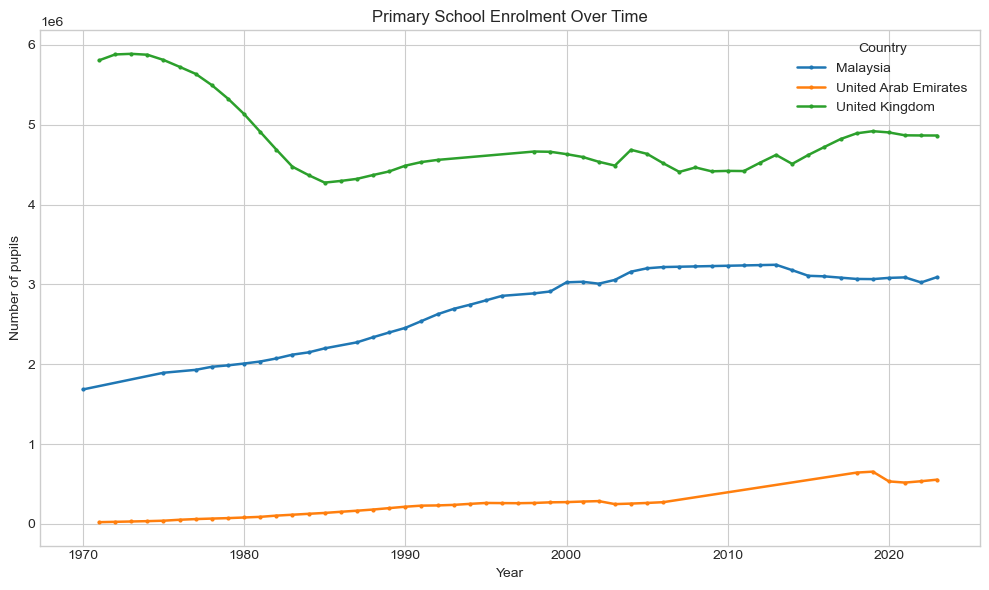

In [30]:
# Use only non-missing enrolment rows for enrolment trend visualisation
df_enrol_plot = df_merged.dropna(subset=["enrolment"]).copy()

plt.figure(figsize=(10, 6))
for c in sorted(df_enrol_plot["country"].unique()):
    sub = df_enrol_plot[df_enrol_plot["country"] == c].sort_values("Year")
    plt.plot(sub["Year"], sub["enrolment"], marker="o", markersize=2, linewidth=1.8, label=c)

plt.title("Primary School Enrolment Over Time")
plt.xlabel("Year")
plt.ylabel("Number of pupils")
plt.legend(title="Country")
plt.tight_layout()
plt.show()


Lines may be discontinuous because enrolment has missing values in some years.
This is expected in the World Bank series and is handled by plotting only available points.


## Population vs enrolment

This chart compares total population with primary school enrolment
to observe whether enrolment follows demographic trends.

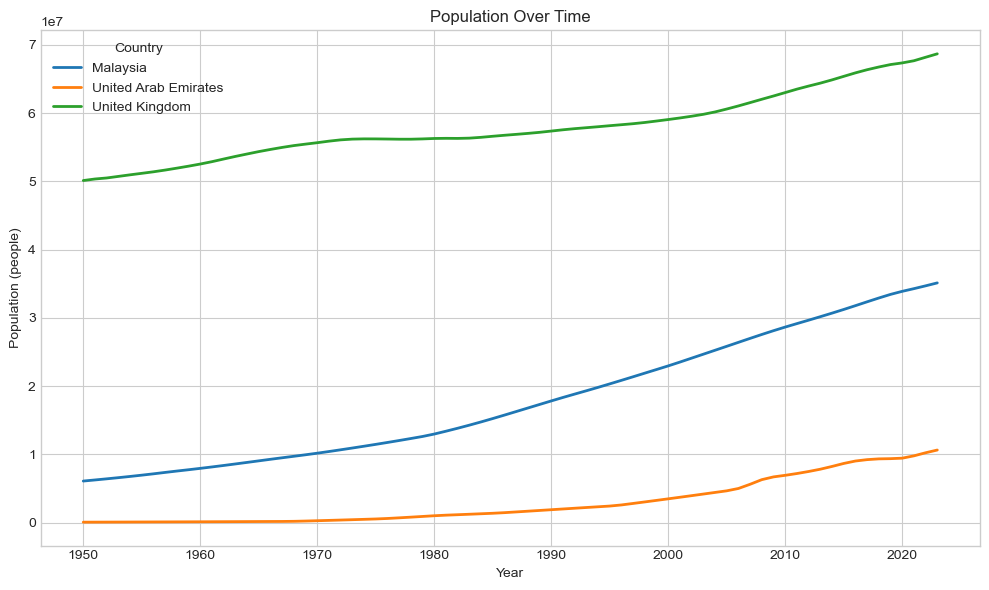

In [31]:
plt.figure(figsize=(10, 6))

for c in sorted(df_merged["country"].unique()):
    sub = df_merged[df_merged["country"] == c].sort_values("Year")
    plt.plot(sub["Year"], sub["population"], linewidth=2, label=c)

plt.title("Population Over Time")
plt.xlabel("Year")
plt.ylabel("Population (people)")
plt.legend(title="Country")
plt.tight_layout()
plt.show()


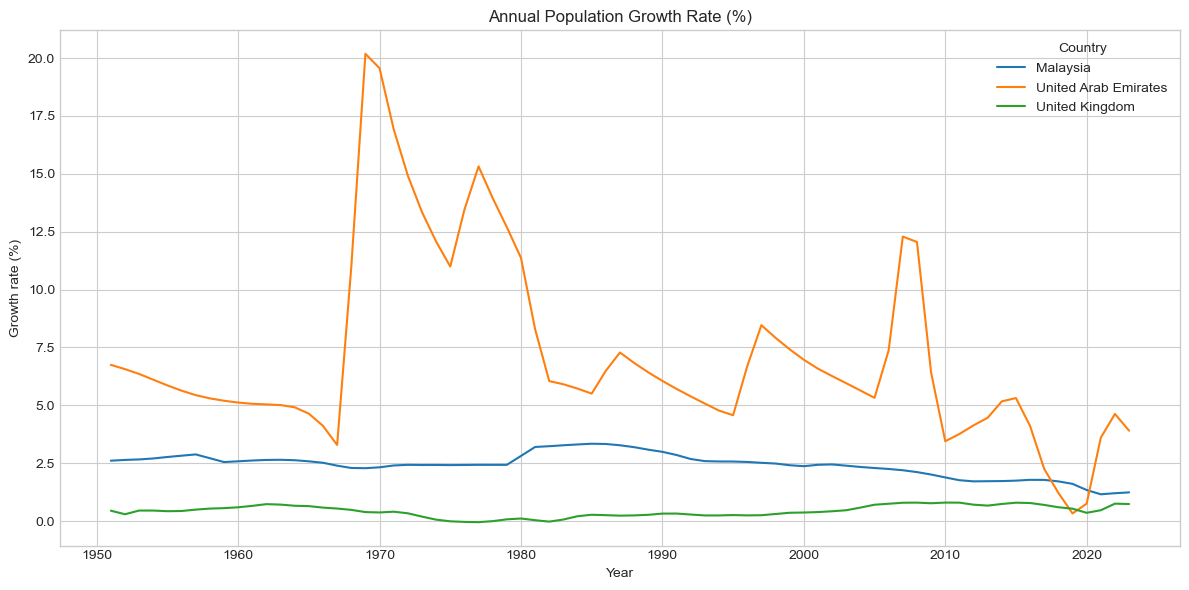

,country,Year,population,pop_growth_rate_pct
0,Malaysia,1950,6098283.0,NaN
1,Malaysia,1951,6257417.0,2.609489
2,Malaysia,1952,6422846.0,2.643727
3,Malaysia,1953,6593943.0,2.663881
4,Malaysia,1954,6772378.0,2.706044
5,Malaysia,1955,6959963.0,2.769854
6,Malaysia,1956,7156626.0,2.825633
7,Malaysia,1957,7362822.0,2.881190
8,Malaysia,1958,7562878.0,2.717110
9,Malaysia,1959,7755786.0,2.550722


In [32]:
df_growth = df_merged.sort_values(["country", "Year"]).copy()
df_growth["pop_growth_rate_pct"] = df_growth.groupby("country")["population"].pct_change() * 100

plt.figure(figsize=(12, 6))
for c in countries:
    temp = df_growth[df_growth["country"] == c]
    plt.plot(temp["Year"], temp["pop_growth_rate_pct"], label=c)

plt.title("Annual Population Growth Rate (%)")
plt.xlabel("Year")
plt.ylabel("Growth rate (%)")
plt.legend(title="Country")
plt.tight_layout()
plt.show()

df_growth[["country", "Year", "population", "pop_growth_rate_pct"]].head(10)


## Net migration trends

Net migration can influence population growth and school enrolment,
especially in countries with high inward migration such as the UAE.

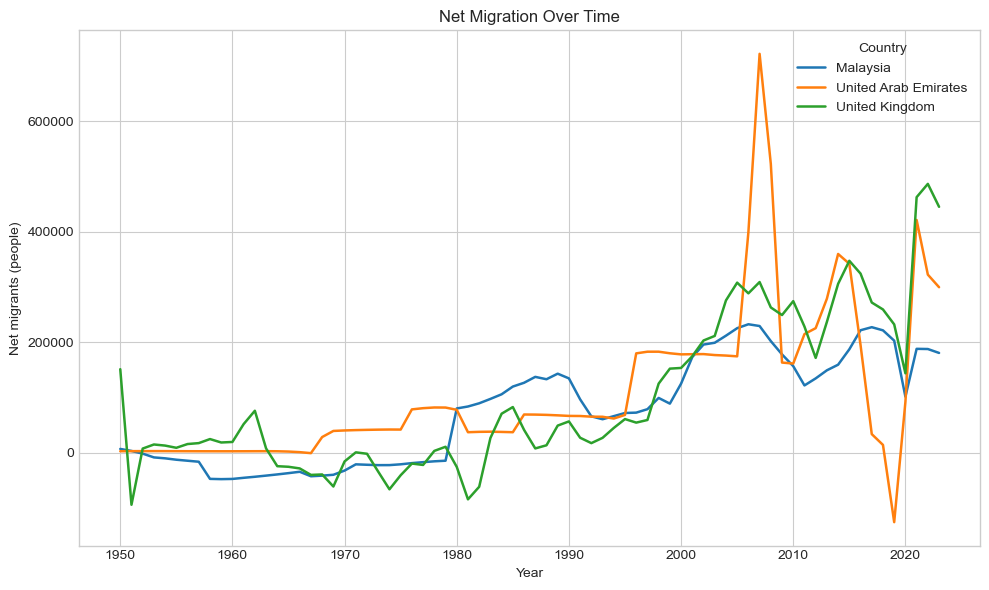

In [33]:
plt.figure(figsize=(10, 6))

for c in sorted(df_merged["country"].unique()):
    sub = df_merged[df_merged["country"] == c].sort_values("Year")
    plt.plot(sub["Year"], sub["net_migrants"], linewidth=1.8, label=c)

plt.title("Net Migration Over Time")
plt.xlabel("Year")
plt.ylabel("Net migrants (people)")
plt.legend(title="Country")
plt.tight_layout()
plt.show()


## Population change vs births, natural change and net migration

To compare population drivers, I compute annual population change as:

`population_change(t) = population(t) - population(t-1)`

Then I visualise it against births, natural change, and net migration for each country.


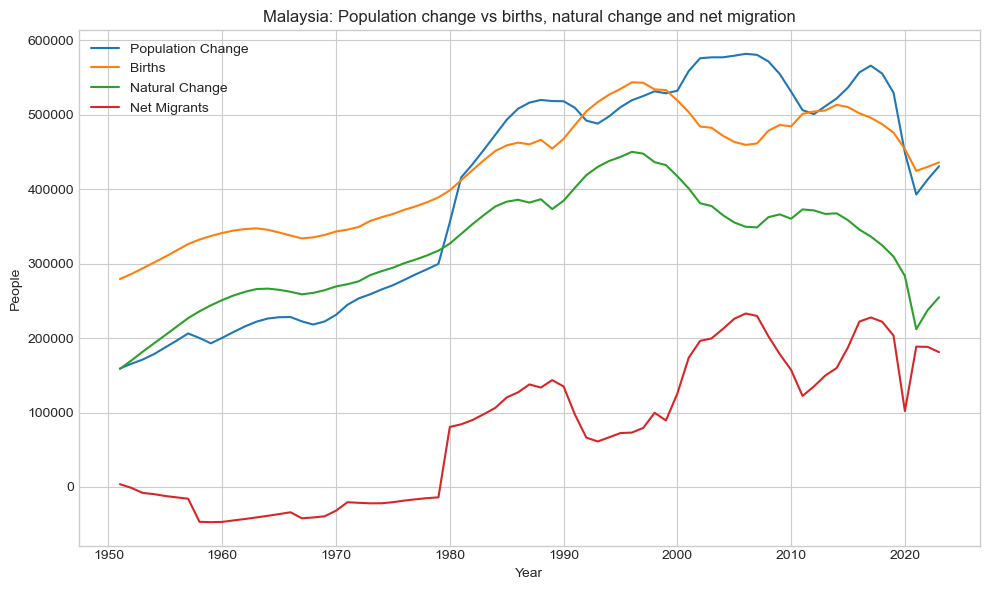

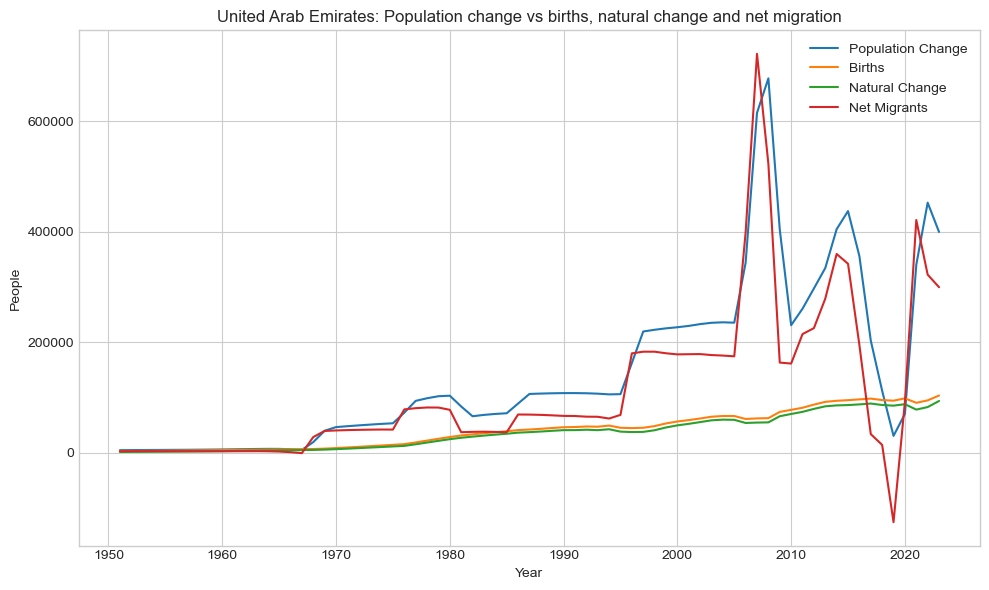

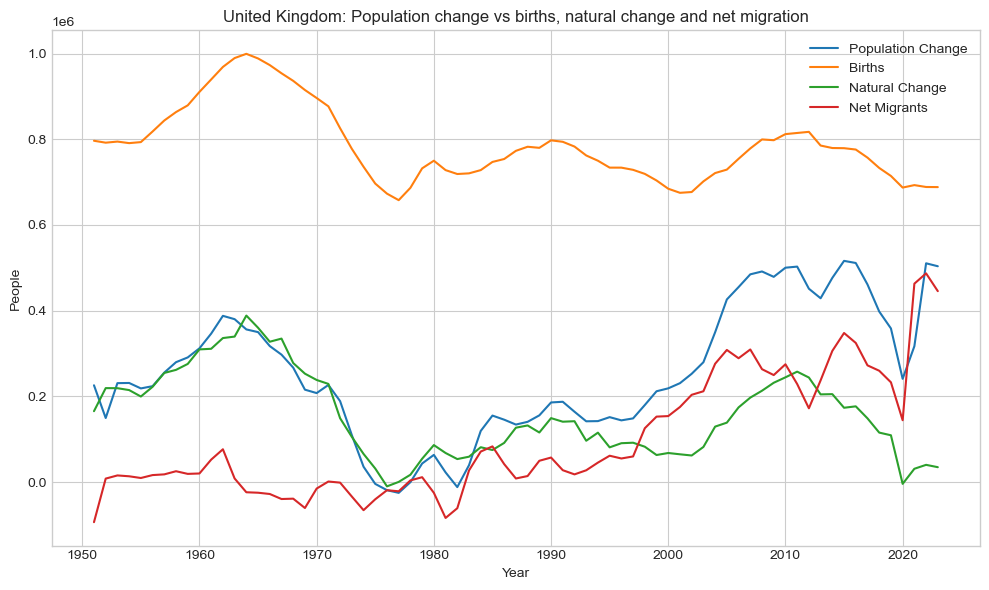

population_change    births  natural_change  net_migrants
country                                                                                          
Malaysia             population_change           1.000000  0.946683        0.836080      0.907525
                     births                      0.946683  1.000000        0.905874      0.771167
                     natural_change              0.836080  0.905874        1.000000      0.537718
                     net_migrants                0.907525  0.771167        0.537718      1.000000
United Arab Emirates population_change           1.000000  0.743721        0.738893      0.934639
                     births                      0.743721  1.000000        0.999636      0.593112
                     natural_change              0.738893  0.999636        1.000000      0.585479
                     net_migrants                0.934639  0.593112        0.585479      1.000000
United Kingdom       population_change           1.000000  0.300556        0.499695      0.739297
                     births                      0.300556  1.000000        0.937541     -0.358163
                     natural_change              0.499695  0.937541        1.000000     -0.167114
                     net_migrants                0.739297 -0.358163       -0.167114      1.000000

In [34]:
# calculate yearly population change
df_merged = df_merged.sort_values(["country", "Year"]).copy()
df_merged["population_change"] = df_merged.groupby("country")["population"].diff()

plot_cols = ["population_change", "births", "natural_change", "net_migrants"]

for c in sorted(df_merged["country"].unique()):
    sub = df_merged[df_merged["country"] == c].dropna(subset=["population_change"]).copy()

    plt.figure(figsize=(10, 6))
    for col in plot_cols:
        plt.plot(sub["Year"], sub[col], label=col.replace("_", " ").title())

    plt.title(f"{c}: Population change vs births, natural change and net migration")
    plt.xlabel("Year")
    plt.ylabel("People")
    plt.legend()
    plt.tight_layout()
    plt.show()

# simple numeric check: correlation with population change by country
corr_table = (
    df_merged.dropna(subset=["population_change"])
    .groupby("country")[["population_change", "births", "natural_change", "net_migrants"]]
    .corr()
)
corr_table


## Discussion of findings

Across the three countries, population dynamics differ in scale and in main drivers:

- **Malaysia:** population and births rise steadily for much of the period, so natural change contributes strongly to population growth.
- **United Kingdom:** overall growth is slower and more stable; births and deaths are closer in magnitude than in Malaysia.
- **United Arab Emirates:** migration plays a much larger role, with visibly larger fluctuations in net migrants over time.

Comparing annual population change with births, natural change, and net migration shows that no single factor explains all years equally. However, patterns in the plots and correlation table support the interpretation that:
- natural change is an important baseline contributor,
- migration is especially influential for the UAE,
- and demographic pressure on enrolment differs by national context.

These findings are consistent with UN and World Bank demographic reporting and country-level migration publications listed in the references.


## Eligible Primary Age Population vs Actual Enrolment

This chart compares the estimated eligible primary school age population 
with the actual primary school enrolment numbers for the UK, UAE and Malaysia.

This allows us to observe whether enrolment trends follow demographic trends.

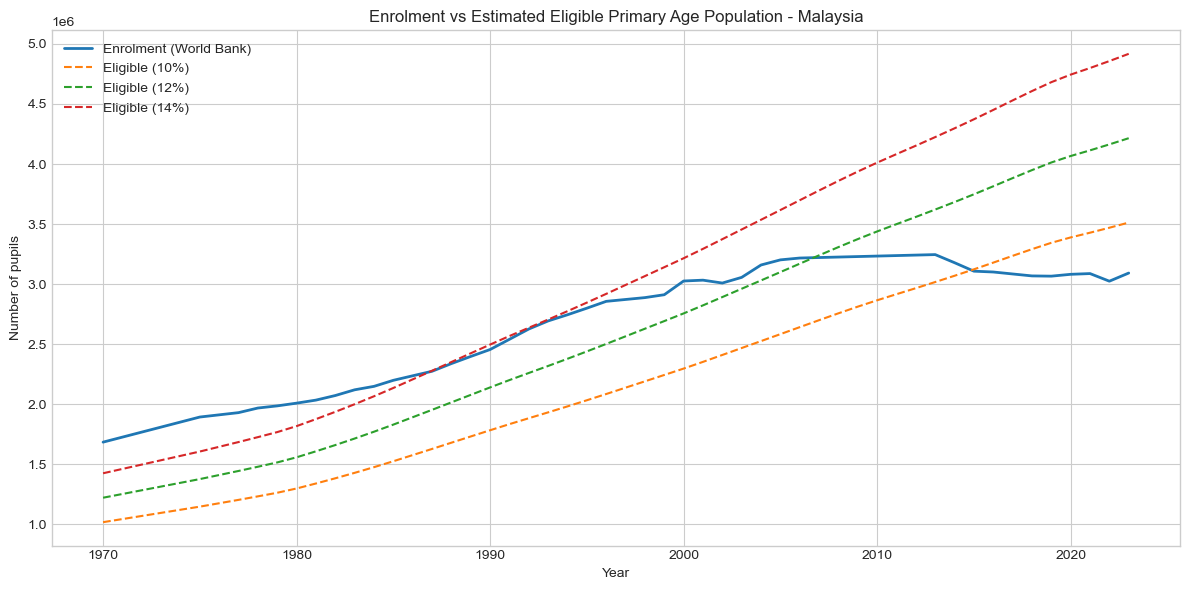

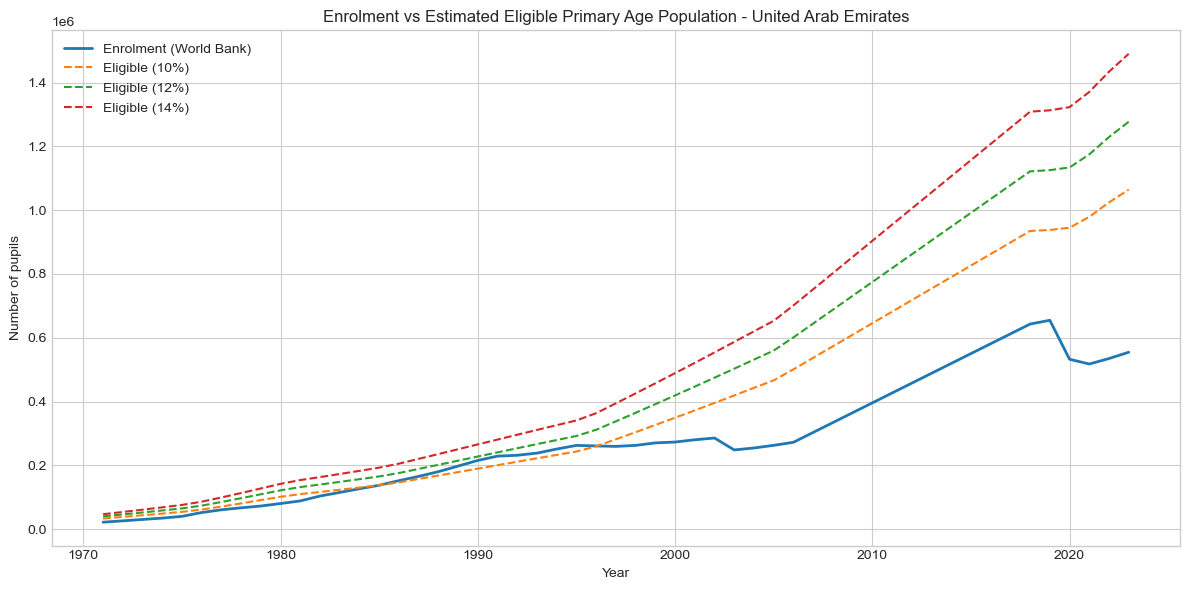

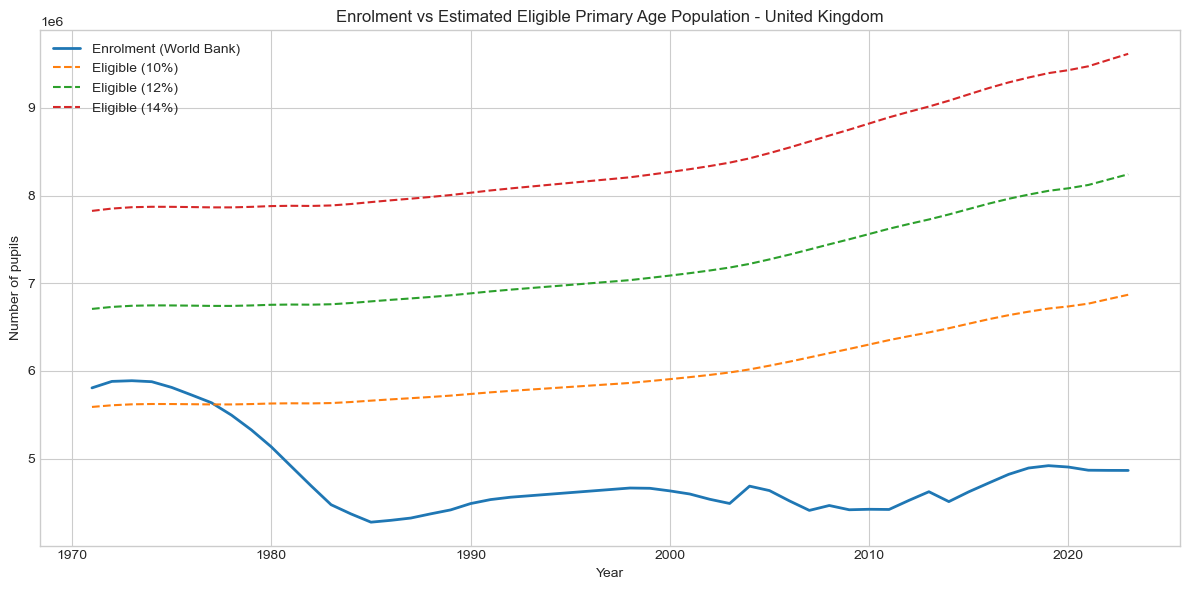

In [35]:
# Compare enrolment with eligible-population scenarios (10%, 12%, 14%)
for c in sorted(df_merged["country"].unique()):
    temp = df_merged[df_merged["country"] == c].dropna(subset=["enrolment"]).sort_values("Year")

    plt.figure(figsize=(12, 6))
    plt.plot(temp["Year"], temp["enrolment"], label="Enrolment (World Bank)", linewidth=2)
    plt.plot(temp["Year"], temp["eligible_10pct"], linestyle="--", label="Eligible (10%)")
    plt.plot(temp["Year"], temp["eligible_12pct"], linestyle="--", label="Eligible (12%)")
    plt.plot(temp["Year"], temp["eligible_14pct"], linestyle="--", label="Eligible (14%)")

    plt.title(f"Enrolment vs Estimated Eligible Primary Age Population - {c}")
    plt.xlabel("Year")
    plt.ylabel("Number of pupils")
    plt.legend()
    plt.tight_layout()
    plt.show()


## Insights

Main conclusions from the visual and statistical checks:

1. **Population growth is not identical across the three countries.**
   Malaysia and the UK show steadier long-run trends, while the UAE shows larger migration-linked swings.

2. **Natural change and migration contribute differently by country.**
   Natural change is an important contributor in all three, but migration is clearly more dominant for UAE variability.

3. **Enrolment broadly follows demographic pressure but not perfectly.**
   The estimated eligible-population curves and actual enrolment are directionally related, but the gap changes over time.

4. **Sensitivity check (10%–14%) keeps conclusions similar.**
   This increases confidence that the interpretation is not dependent on one exact percentage assumption.

Overall, the coursework question is supported: demographic factors (population growth, natural change, and migration) are linked to primary school enrolment trends, but with country-specific differences.


## Limitations and scope

To keep interpretation accurate, the following limitations should be considered:

1. **Missing enrolment years:** the World Bank series has gaps for some country-years, so not every comparison uses a continuous full-period series.
2. **Approximation in eligible population:** the 12% primary-age share is a practical proxy rather than exact yearly age-structure data for each country.
3. **Cross-source comparability:** UN demographic estimates and World Bank indicator series may differ in methodology and revision timing.
4. **Association vs causation:** visual/correlation-based patterns show relationships, but do not by themselves prove causal effects.

The sensitivity analysis (10%/12%/14%) is included to reduce dependence on one single assumption and improve robustness of interpretation.


## References

United Nations (2024) World Population Prospects 2024. Available at:
https://population.un.org/wpp/
 (Accessed: 21 February 2026).

World Bank (2024a) Primary school enrolment, total (SE.PRM.ENRL). Available at:
https://data.worldbank.org/indicator/SE.PRM.ENRL
 (Accessed: 21 February 2026).

World Bank (2024b) Population, total (SP.POP.TOTL). Available at:
https://data.worldbank.org/indicator/SP.POP.TOTL
 (Accessed: 21 February 2026).

Office for National Statistics (ONS) (2024) International migration, UK. Available at:
https://www.ons.gov.uk/peoplepopulationandcommunity/populationandmigration/internationalmigration
(Accessed: 21 February 2026).

Department of Statistics Malaysia (DOSM) (2024) Population and demographic statistics. Available at:
https://www.dosm.gov.my/
 (Accessed: 21 February 2026).